In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
from scipy import interpolate


In [2]:
def create_user_input_dict(age_begin, age_end, risk_groups, all_jurisdictions, max_ep_len, 
                           simul_time_steps, simul_begin_year, simulating_years):
    
    global user_input_dict
    
    
    user_input_dict = {"age_begin": age_begin,
                       "age_end": age_end,
                       "num_age_groups": age_end-age_begin+1,
                       "risk_groups": risk_groups,
                       "number_of_risk_groups": len(risk_groups),
                       "all_jurisdictions": all_jurisdictions,
                       "num_jur": len(all_jurisdictions),
                       "max_ep_len": max_ep_len,
                       "simul_time_steps": simul_time_steps,
                       "dt": 1/simul_time_steps,
                       "simul_begin_year": simul_begin_year,
                       "simulating_years": simulating_years
                      }
    

In [3]:
def read_inputs(): # Read any parameters related to nthe calculation of new infections
    
    # Creating a global variable
    global compartmental_inputs_dict
    
    # Reading the path of the input file
    cwd = os.getcwd()
    file_name = 'compartmental_model_inputs.xlsx'
    
    file_path = os.path.join(cwd, "input_files", file_name)
    
    # Each file is mapped to a dictionary
    compartmental_inputs_dict = pd.read_excel(file_path, sheet_name=None) 
    
    
    # Keys of the dictionary are printed (uncomment the following function)
    #print("Dictionary keys are :\n", compartmental_inputs_dict.keys(), "\n\n")
    

In [4]:
def create_other_inputs():
    
    condom_awareness = np.array([0,0.53,0.53,0.53])
    
    pop_growth_rate = 0

    gamma = np.array([[0.5,0.5,0.5,0.5,1],
                      [0.5,0.5,0.5,0.5,1],
                      [0.5,0.5,0.5,0.5,1]])

    scaling_factor_dropout = np.array([[1,1,1,1,1,1,1,1,0,0],
                                       [1,1,1,1,1,1,1,1,0,0],
                                       [1,1,1,1,1,1,1,1,0,0]])
    
    unaware_index = (1,5,9,13,17)
    aware_no_care_index = (2,6,10,14,18)
    ART_VLS_index = (3,4,7,8,11,12,15,16,19,20)
    VLS_index = (4,8,12,16,20)
    
    prep_efficiency = 0.99
    
    number_of_compartments = len(unaware_index)+len(aware_no_care_index)+len(ART_VLS_index)+2
    number_of_inf_compartments = len(unaware_index)+len(aware_no_care_index)+len(ART_VLS_index)
    

    global other_inputs_dict
    other_inputs_dict = {"condom_awareness": condom_awareness,
                         "pop_growth_rate": pop_growth_rate,
                         "gamma": gamma,
                         "scaling_factor_dropout": scaling_factor_dropout,
                         "unaware_index": unaware_index,
                         "aware_no_care_index": aware_no_care_index,
                         "ART_VLS_index": ART_VLS_index,
                         "VLS_index": VLS_index,
                         "prep_efficiency": prep_efficiency,
                         "number_of_compartments": number_of_compartments,
                         "number_of_inf_compartments": number_of_inf_compartments
                        }

In [5]:
def generate_global_age_mixing_mat():
    
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    num_age_groups = user_input_dict["num_age_groups"]
    
    global age_mixing_final_mat
    age_mixing_final_mat = np.empty((0, age_end-age_begin+1))

    for i in range(len(risk_groups)):
        key = "AgeMix"+risk_groups[i]
        age_mixing_input = compartmental_inputs_dict[key]
        age_mixing_matrix_expand = generate_indiv_risk_age_mixing_mat(age_mixing_input)
        age_mixing_final_mat = np.vstack((age_mixing_final_mat, age_mixing_matrix_expand))
    age_mixing_final_mat = age_mixing_final_mat.reshape((number_of_risk_groups, num_age_groups, num_age_groups))

        
def generate_indiv_risk_age_mixing_mat(age_mat):

    col_names = list(age_mat.columns.values)

    if col_names[0] != age_begin:
        col_names.insert(0, age_begin)

    if col_names[-1] != age_end:
        col_names.append(age_end+1)

    diff_arr = np.diff(col_names)

    indiv_age_mat = []
    for i in range(len(col_names)-1):
        rep_arr_col_wise = np.repeat(age_mat.values[i,:], diff_arr)
        diff_arr_rep = np.repeat(diff_arr, diff_arr)
        rep_arr_col_wise_indiv = np.nan_to_num(np.divide(rep_arr_col_wise, diff_arr_rep, 
                                                         out = np.zeros_like(rep_arr_col_wise), where=diff_arr_rep!=0))
        for j in range(diff_arr[i]):
            indiv_age_mat.append(rep_arr_col_wise_indiv)
    indiv_age_mat = np.array(indiv_age_mat)/100

    return indiv_age_mat 

In [6]:
def gather_prep_values():
    
    num_jur = user_input_dict["num_jur"]
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    all_jurisdictions = user_input_dict["all_jurisdictions"]
    
    global prep_value_init

    prep_value_init = np.zeros((num_jur,number_of_risk_groups))
    
    df_prep = compartmental_inputs_dict["PrepValues"]
    
    df_prep_clus = df_prep.loc[df_prep['FIPS'].isin(all_jurisdictions)]
    
    prep_rates_clus = df_prep_clus['Prep'].values
    prep_eligible = df_prep_clus['PrEP Eligible'].values
    prep_value_init[:,2] = prep_rates_clus/100
    


In [7]:
def prep_new_inf_inputs():
    
    number_of_compartments = other_inputs_dict["number_of_compartments"]
    number_of_inf_compartments = other_inputs_dict["number_of_inf_compartments"]
    num_risk_groups = user_input_dict["number_of_risk_groups"]
    num_age_groups = user_input_dict["num_age_groups"]
    risk_groups = user_input_dict["risk_groups"]
    
    """###"""
    q = compartmental_inputs_dict["qmat"].values.reshape(number_of_compartments,number_of_compartments)
    
    
    """###"""
    condom_efficiency = compartmental_inputs_dict["condom_efficiency"].values[0,0]
    
    """###"""
    pi = compartmental_inputs_dict["pi"].values.reshape(number_of_inf_compartments)
    
    """###"""
    num_sex_acts = compartmental_inputs_dict["num_sex_acts"]
    
    """###"""
    number_of_sex_acts_risk_age = np.zeros((num_risk_groups, num_age_groups))
    
    sex_act_calibration_param = [0.44, 90000000000000000, 90000000000000000]
    
    for risk in range(num_risk_groups):
        current_risk_group = risk_groups[risk]
        for age_index in range(num_age_groups):
            current_age = age_index+age_begin
    
            if((current_risk_group == 'HM') | (current_risk_group == "MSM") | (current_risk_group == "MSMIDU") | (current_risk_group == "IDUM")):
                upper = num_sex_acts[(num_sex_acts['Age_group'] == current_age)].Male_Upper.values
                lower = num_sex_acts[(num_sex_acts['Age_group'] == current_age)].Male_Lower.values
                
            elif((current_risk_group == 'HF') | (current_risk_group == "IDUF")):
                upper = num_sex_acts[(num_sex_acts['Age_group'] == current_age)].Female_Upper.values
                lower = num_sex_acts[(num_sex_acts['Age_group'] == current_age)].Female_Lower.values
            
            number_of_sex_acts_risk_age[risk,age_index] = lower+((upper-lower)/sex_act_calibration_param[risk])
    
    """###"""
    prop_anal_acts = np.zeros((num_risk_groups, num_age_groups))
    prop_acts_pd = compartmental_inputs_dict["prop_anal_acts"]

    for risk in range(num_risk_groups):
        current_risk = risk_groups[risk]
        prop_anal_acts[risk] = prop_acts_pd[current_risk].values
    
    """###"""
    prop_casual_partner_v = compartmental_inputs_dict["prop_casual_partner"]
    prop_casual_partner_risk = np.zeros((num_risk_groups, 2)) #columns [0]prob_casual	[1]prob_casual_only
    
    for risk in range(num_risk_groups):
        current_risk_group = risk_groups[risk]
        prop_casual_partner_risk[risk] = prop_casual_partner_v[(prop_casual_partner_v['Group'] == current_risk_group)].values[:,1:3]
    
    """###"""
    prop_casual_partner_risk_casual = prop_casual_partner_risk[:,0]
    prop_casual_partner_risk_casual_only = prop_casual_partner_risk[:,1]
    
    """###"""
    num_partner = compartmental_inputs_dict["num_partner"]
    num_partner_risk = np.zeros((num_risk_groups,2))
    
    for risk in range(num_risk_groups):
        current_risk_group = risk_groups[risk]
        num_partner_risk[risk] = num_partner[(num_partner['Group'] == current_risk_group)].values[:,1:3]
    
    num_partner_risk_casual_only = num_partner_risk[:,0]
    num_partner_risk_casual = num_partner_risk[:,1]
    
    """###"""
    num_cas_part_main_cas = compartmental_inputs_dict["num_cas_part_main-cas"].values
    
    """###"""
    prop_condom_use = compartmental_inputs_dict["prop_condom_use"]
    prop_condom_use_risk_age_casual = np.zeros((num_risk_groups, num_age_groups))
    prop_condom_use_risk_age_main = np.zeros((num_risk_groups, num_age_groups))
    
    prop_condom_use_risk_age_main[0] = prop_condom_use.values[:,3]
    prop_condom_use_risk_age_main[1] = prop_condom_use.values[:,1]
    prop_condom_use_risk_age_main[2] = prop_condom_use.values[:,5]
    
    prop_condom_use_risk_age_casual[0] = prop_condom_use.values[:,4]
    prop_condom_use_risk_age_casual[1] = prop_condom_use.values[:,2]
    prop_condom_use_risk_age_casual[2] = prop_condom_use.values[:,6]
    
    """###"""    
    trans_prob = compartmental_inputs_dict["trans_prob"]
    trans_prob_v_acts = np.zeros((num_risk_groups))
    trans_prob_a_acts = np.zeros((num_risk_groups))
    
    for risk in range(num_risk_groups):
        current_risk_group = risk_groups[risk]
        trans_prob_v_acts[risk] = trans_prob[(trans_prob['Group'] == current_risk_group)].vaginal.values
        trans_prob_a_acts[risk] = trans_prob[(trans_prob['Group'] == current_risk_group)].anal.values
   
    """###""" 
    sex_mixing = compartmental_inputs_dict["sex_mixing"].values
        
    """###""" 
    #excel = 'input_estimating_unknown_rates_PATH.xlsx'
    testing_mult_fac = compartmental_inputs_dict["testing_mult_fac"]
    testing_mult_fac_risk = np.zeros((num_risk_groups,5))
    
    for risk in range(num_risk_groups):
        current_risk_group = risk_groups[risk]
        testing_mult_fac_risk[risk] = testing_mult_fac[current_risk_group]
        
    """###"""     
    global new_inf_inputs_dict
    
    new_inf_inputs_dict = {"q": q,
                           "condom_efficiency": condom_efficiency,
                           "pi": pi,
                           "number_of_sex_acts_risk_age": number_of_sex_acts_risk_age,
                           "prop_anal_acts": prop_anal_acts,
                           "prop_casual_partner_risk_casual": prop_casual_partner_risk_casual,
                           "prop_casual_partner_risk_casual_only": prop_casual_partner_risk_casual_only,
                           "num_partner_risk_casual": num_partner_risk_casual,
                            "num_partner_risk_casual_only": num_partner_risk_casual_only,
                            "num_cas_part_main_cas": num_cas_part_main_cas,
                            "prop_condom_use_risk_age_main": prop_condom_use_risk_age_main,
                            "prop_condom_use_risk_age_casual": prop_condom_use_risk_age_casual,
                            "trans_prob_v_acts": trans_prob_v_acts,
                            "trans_prob_a_acts": trans_prob_a_acts,
                            "sex_mixing": sex_mixing,
                            "testing_mult_fac_risk": testing_mult_fac_risk,
                          }
    
    

In [8]:
def prep_ltc_values():
    
    jur_list = user_input_dict["all_jurisdictions"]
    num_jur = user_input_dict["num_jur"]
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]

    df_hm_ltc = compartmental_inputs_dict["jur_specific_care_cont_hm"]
    df_hf_ltc = compartmental_inputs_dict["jur_specific_care_cont_hf"]
    df_msm_ltc = compartmental_inputs_dict["jur_specific_care_cont_msm"]
    
    global ltc_risk
    ltc_risk = np.zeros((num_jur, number_of_risk_groups))
    
    for loc in range(len(jur_list)):
        d_hm = df_hm_ltc[df_hm_ltc['FIPS']==jur_list[loc]]
        d_hf = df_hf_ltc[df_hf_ltc['FIPS']==jur_list[loc]]
        d_msm = df_msm_ltc[df_msm_ltc['FIPS']==jur_list[loc]]

        ltc_vals = np.array([d_hm.LTC.values[0],
                             d_hf.LTC.values[0],
                             d_msm.LTC.values[0]])
        
        ltc_risk[loc] = ltc_vals
    


In [9]:
def read_death_rates():
    
    num_risk_groups = user_input_dict["number_of_risk_groups"]
    num_age_groups = user_input_dict["num_age_groups"]
    
    
    death_rate_a200_age_2010 = 0    
    death_rate_a200_age_2016 = 0
    death_rate_b200_age_2010 = 0
    death_rate_b200_age_2016 = 0
    death_rate_inf_v = 0

    #The following lines of code are used if I used MOD dataset
    death_rate_uninf = compartmental_inputs_dict["death_prob_uninf"]
    death_rate_inf_no_art = compartmental_inputs_dict["death_prob_inf_no_art"]
    death_prob_inf_art = compartmental_inputs_dict["death_prob_inf_art"]
    
    death_rate_uninf_risk_age = np.zeros((num_risk_groups, num_age_groups))
    
    for risk in range(num_risk_groups):
        current_risk_group = risk_groups[risk]
        
        death_rate_uninf_risk_age[risk] = death_rate_uninf[current_risk_group].values
    
    
    death_rate_inf_no_ART_acute = death_rate_inf_no_art[(death_rate_inf_no_art['CD4_category'] == "Acute")]["death_rate"].values
    death_rate_inf_no_ART_above_500 = death_rate_inf_no_art[(death_rate_inf_no_art['CD4_category'] == "CD4 >500")]["death_rate"].values
    death_rate_inf_no_ART_above_350_500 = death_rate_inf_no_art[(death_rate_inf_no_art['CD4_category'] == "CD4 350-500")]["death_rate"].values
    death_rate_inf_no_ART_above_200_350 = death_rate_inf_no_art[(death_rate_inf_no_art['CD4_category'] == "CD4 200-350")]["death_rate"].values
    death_rate_inf_no_ART_below_200 = death_rate_inf_no_art[(death_rate_inf_no_art['CD4_category'] == "CD4 <200")]["death_rate"].values
    
    death_rate_inf_ART_below_200_age = death_prob_inf_art["CD4_b_200"].values
    death_rate_inf_ART_200_350_age = death_prob_inf_art["CD4_200_350"].values
    death_rate_inf_ART_above_350_age = death_prob_inf_art["CD4_a_350"].values
    
    
    global death_prob_data
    death_prob_data = {
        "death_rate_uninf_risk_age": death_rate_uninf_risk_age,
        "death_rate_inf": death_rate_inf_v,
        "death_rate_a200_age_2010": death_rate_a200_age_2010,
        "death_rate_a200_age_2016": death_rate_a200_age_2016,
        "death_rate_b200_age_2010": death_rate_b200_age_2010,
        "death_rate_b200_age_2016": death_rate_b200_age_2016,
        "death_rate_inf_no_ART_acute": death_rate_inf_no_ART_acute,
        "death_rate_inf_no_ART_above_500": death_rate_inf_no_ART_above_500,
        "death_rate_inf_no_ART_above_350_500": death_rate_inf_no_ART_above_350_500,
        "death_rate_inf_no_ART_above_200_350": death_rate_inf_no_ART_above_200_350,
        "death_rate_inf_no_ART_below_200": death_rate_inf_no_ART_below_200,
        "death_rate_inf_ART_below_200_age": death_rate_inf_ART_below_200_age,
        "death_rate_inf_ART_200_350_age": death_rate_inf_ART_200_350_age,
        "death_rate_inf_ART_above_350_age": death_rate_inf_ART_above_350_age}
    
    
    

In [10]:
def extract_yearly_care_continuum_target_proportions():
    
    care_cont_targets_jur_df = compartmental_inputs_dict["care_cont_targets_jur"]

    all_jurs = user_input_dict["all_jurisdictions"]
    num_risk_groups = user_input_dict["number_of_risk_groups"]
    risk_groups = user_input_dict["risk_groups"]
    
    global care_cont_targets_all_jurs
    care_cont_targets_all_jurs = {}
    
    for i in range(len(all_jurs)):
        key_i = all_jurs[i]
        df = care_cont_targets_jur_df[care_cont_targets_jur_df["FIPS"] == key_i]
        care_cont_targets_all_jurs[key_i] = df
        

In [11]:
def reshape_care_continuum_target_proportions():
    
    
    all_jurs = user_input_dict["all_jurisdictions"]
    num_jurs = user_input_dict["num_jur"]
    risk_groups = user_input_dict["risk_groups"]
    num_risk_groups = user_input_dict["number_of_risk_groups"]
    years_list_df = np.unique(care_cont_targets_all_jurs[all_jurs[0]]["Year"].values)
    num_years_df = len(years_list_df)
    care_cont_levels = care_cont_targets_all_jurs[all_jurs[0]].columns.tolist()[3:]
    
    global care_cont_target_reshape
    care_cont_target_reshape = np.zeros((num_years_df, num_jurs, num_risk_groups, len(care_cont_levels)))
    
    for i in range(num_years_df):
        for j in range(num_jurs):
            for k in range(num_risk_groups):
                    
                df_jur = care_cont_targets_all_jurs[all_jurs[j]]
                df_yr = df_jur[(df_jur['Year'] == years_list_df[i])]
                df_risk = df_yr[(df_yr['Risk'] == risk_groups[k])]
                
                care_cont_target_reshape[i,j,k] = df_risk.values[0][3:]


In [12]:
def prep_inputs():
    generate_global_age_mixing_mat()
    gather_prep_values()
    prep_new_inf_inputs()
    prep_ltc_values()
    read_death_rates()
    extract_yearly_care_continuum_target_proportions()
    reshape_care_continuum_target_proportions()

In [13]:
def create_data_cluster():

    num_jur = user_input_dict["num_jur"]
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    num_age_groups = user_input_dict["num_age_groups"]
    number_of_compartments = other_inputs_dict["number_of_compartments"]

    global data_array_cluster_init
    data_array_cluster_init = np.zeros((num_jur, number_of_risk_groups, num_age_groups, number_of_compartments))

    for jur_ind in range(num_jur):
        
        cwd = os.getcwd()
        input_file = 'jurisdiction_pop_dist.xlsx'
        file_path = os.path.join(cwd, "input_files", input_file)
        df1 = pd.read_excel(file_path, sheet_name=str(all_jurisdictions[jur_ind]), index_col=0)
        
        data_array_cluster_init[jur_ind] = df1.iloc[:,3:].to_numpy().reshape(number_of_risk_groups,
                                                                        num_age_groups,
                                                                        number_of_compartments)

In [14]:
def calculate_proportions(data_array, num_jur):
     
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    
    unaware_index = other_inputs_dict["unaware_index"]
    aware_no_care_index = other_inputs_dict["aware_no_care_index"]
    ART_VLS_index = other_inputs_dict["ART_VLS_index"]
    VLS_index = other_inputs_dict["VLS_index"]
    
    plwh_risk = np.zeros((num_jur, number_of_risk_groups))
    unaware_risk = np.zeros((num_jur, number_of_risk_groups))
    aware_no_art_risk = np.zeros((num_jur, number_of_risk_groups))
    aware_art_vls_risk = np.zeros((num_jur, number_of_risk_groups))
    vls_risk = np.zeros((num_jur, number_of_risk_groups))
   

    for risk in range(number_of_risk_groups):

        #total infected
        plwh_risk[:,risk] = np.apply_over_axes(np.sum, data_array[:,risk,:,1:21], [1,2]).reshape(num_jur,)

        #total unaware
        unaware_risk[:,risk] = np.apply_over_axes(np.sum, data_array[:,risk,:,unaware_index], [0,2]).reshape(num_jur,)

        #total aware no art
        aware_no_art_risk[:,risk] = np.apply_over_axes(np.sum, data_array[:,risk,:,aware_no_care_index], [0,2]).reshape(num_jur,)

        #total art vls
        aware_art_vls_risk[:,risk] = np.apply_over_axes(np.sum, data_array[:,risk,:,ART_VLS_index], [0,2]).reshape(num_jur,)

        #total vls
        vls_risk[:,risk] = np.apply_over_axes(np.sum, data_array[:,risk,:,VLS_index], [0,2]).reshape(num_jur,)

    #total population
    total_pop = np.apply_over_axes(np.sum, data_array[:,:,:,0:21], [1,2,3]).reshape(num_jur,1)

    prevalence_prop = plwh_risk/total_pop

    unaware_prop = unaware_risk/plwh_risk
    aware_no_art_prop = aware_no_art_risk/plwh_risk
    aware_art_vls_prop = aware_art_vls_risk/plwh_risk
    vls_prop = vls_risk/plwh_risk

    return total_pop, np.round(prevalence_prop, 6), np.round(unaware_prop, 6), \
            np.round(aware_no_art_prop, 6), np.round(aware_art_vls_prop, 6), vls_prop


In [15]:
def extract_state(data_array, prep_vals):
    
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    num_jur = user_input_dict["num_jur"]
       
    extract_state_ops = []
    for ind in range(num_jur):
        
        cluster_index = np.array([ind])
        data_array_cluster = data_array[cluster_index,:,:,:]
        total_data = np.sum(data_array_cluster, axis=0)
        total_data = total_data[np.newaxis,:,:,:]
        
    
        curr_num_jur = 1
        

        #calculate proportions (prevalence, unaware, aware no art, aware art)
        (total_pop, 
         prevalence_prop, 
         unaware_prop, 
         aware_no_art_prop,
         aware_art_vls_prop,
         vls_prop) = calculate_proportions(total_data, curr_num_jur)

        #multiply susceptible msm numbers with prep coverage and get prep proportion among msm
        prep_coverage = data_array_cluster[:,2,:,0]*prep_vals[cluster_index,2][:,np.newaxis]
        prep = np.round(np.apply_over_axes(np.sum, prep_coverage, [0,1]).item()\
                        /np.apply_over_axes(np.sum, data_array_cluster[:,2,:,0], [0,1]).item(), 4)
        prep_prop = np.array([0,0,prep])
        
        #get the state information(prevalane prop, unaware prop, aware no art prop, art prop, prep prop)
        current_state = np.transpose(np.vstack((prevalence_prop, 
                                                unaware_prop, 
                                                aware_no_art_prop, 
                                                aware_art_vls_prop, 
                                                prep_prop)))
        
        extract_state_ops.append(current_state)

    return extract_state_ops

In [16]:
def initial_state(initial_data, prep_values):
    
    state_outputs = extract_state(initial_data, prep_values)
    time = 0
    return initial_data, state_outputs, prep_values, time

In [17]:
def M_x1_y1_value():
    
    num_risk = user_input_dict["number_of_risk_groups"]
    dt = user_input_dict["dt"]
    number_of_inf_compartments = other_inputs_dict["number_of_inf_compartments"]
    
    
    condom_awareness = other_inputs_dict["condom_awareness"]
    
    prob_condom_efficency = new_inf_inputs_dict["condom_efficiency"]
    
    c = np.tile(condom_awareness,5).reshape(number_of_inf_compartments)
    
    pi_v = new_inf_inputs_dict["pi"].reshape((number_of_inf_compartments))

    pi = pi_v[np.newaxis,:]
    p_v_x1 = new_inf_inputs_dict["trans_prob_v_acts"].copy()[:,np.newaxis]
    p_a_x1 = new_inf_inputs_dict["trans_prob_a_acts"].copy()[:,np.newaxis]

    p_bar_v_x1 = (1-prob_condom_efficency)*p_v_x1
    p_bar_a_x1 = (1-prob_condom_efficency)*p_a_x1
    
    num_sex_acts = new_inf_inputs_dict["number_of_sex_acts_risk_age"].copy()
    prob_anal_acts = new_inf_inputs_dict["prop_anal_acts"].copy()
    n_v_x1_y1 = num_sex_acts*(1-prob_anal_acts)
    n_a_x1_y1 = num_sex_acts*prob_anal_acts
    
    num_cas_part_main_cas = new_inf_inputs_dict["num_cas_part_main_cas"].copy()[0:num_risk]
    nc = (num_cas_part_main_cas*2)/(num_sex_acts)
    nm = 1-nc
    
    prob_casual_only = new_inf_inputs_dict["prop_casual_partner_risk_casual_only"].copy()[:,np.newaxis]
    prob_casual = new_inf_inputs_dict["prop_casual_partner_risk_casual"].copy()[:,np.newaxis]

    prob_condom_casual = new_inf_inputs_dict["prop_condom_use_risk_age_casual"].copy()
    prob_condom_main = new_inf_inputs_dict["prop_condom_use_risk_age_main"].copy()

    prop_condom_use_calc = ((prob_casual_only*prob_condom_casual)+                                     #only casual
                                        (abs(prob_casual-prob_casual_only)*prob_condom_casual*nc)+ #casual among casual-main
                                        (abs(prob_casual-prob_casual_only)*prob_condom_main*nm)+     #main among casual-main
                                        ((1-prob_casual)*prob_condom_main)) 
    
    num_partners_tot = new_inf_inputs_dict["num_partner_risk_casual"].copy() + \
                        new_inf_inputs_dict["num_partner_risk_casual_only"].copy()
    
    lower1 = (1-(p_bar_v_x1*pi))[:,np.newaxis,:]

    upper1 = ((n_v_x1_y1*dt)[:,:,np.newaxis]*\
              (((1-prop_condom_use_calc)[:,:,np.newaxis]\
                *c[np.newaxis,np.newaxis,:])+\
               prop_condom_use_calc[:,:,np.newaxis]))/(num_partners_tot*dt)[:,np.newaxis,np.newaxis]

    AA = lower1**upper1
    
    lower2 = (1-(p_v_x1*pi))[:,np.newaxis,:]

    upper2 = ((n_v_x1_y1*dt)[:,:,np.newaxis]\
              *(1-prop_condom_use_calc)[:,:,np.newaxis]\
              *(1-c[np.newaxis,np.newaxis,:]))/(num_partners_tot*dt)[:,np.newaxis,np.newaxis]

    BB = lower2**upper2
    
    lower3 = (1-(p_bar_a_x1*pi))[:,np.newaxis,:]

    upper3 = ((n_a_x1_y1*dt)[:,:,np.newaxis]*(((1-prop_condom_use_calc)[:,:,np.newaxis]*c[np.newaxis,np.newaxis,:])+
                                              prop_condom_use_calc[:,:,np.newaxis]))/(num_partners_tot*dt)[:,np.newaxis,np.newaxis]

    CC = lower3**upper3
    
    lower4 = (1-(p_a_x1*pi))[:,np.newaxis,:]

    upper4 = ((n_a_x1_y1*dt)[:,:,np.newaxis]*(1-prop_condom_use_calc)[:,:,np.newaxis]*(1-c[np.newaxis,np.newaxis,:]))/  \
                                            (num_partners_tot*dt)[:,np.newaxis,np.newaxis]

    DD = lower4**upper4
    
    global M_x1_y1_i
    
    M_x1_y1_i = 1-(1-(AA*BB*CC*DD))
    


In [18]:
def generate_jur_mixing_matrix():
    
    num_risk = user_input_dict["number_of_risk_groups"]
    
    jur_mixing_mat_hf = compartmental_inputs_dict["JurMixHETF"]
    jur_mixing_mat_hm = compartmental_inputs_dict["JurMixHETM"]
    jur_mixing_mat_msm = compartmental_inputs_dict["JurMixMSM"]
    
    all_jurs = user_input_dict["all_jurisdictions"].copy()
    jur_list = user_input_dict["all_jurisdictions"].copy()
    jur_list.insert(0, 'FIPS')

    jur_mix_mat_hf_fips = jur_mixing_mat_hf[jur_list]
    jur_mix_mat_hm_fips = jur_mixing_mat_hm[jur_list]
    jur_mix_mat_msm_fips = jur_mixing_mat_msm[jur_list]
    
    jur_mix_mat_hf_row_col = jur_mix_mat_hf_fips[jur_mix_mat_hf_fips['FIPS'].isin(all_jurs)]
    jur_mix_mat_hm_row_col = jur_mix_mat_hm_fips[jur_mix_mat_hm_fips['FIPS'].isin(all_jurs)]
    jur_mix_mat_msm_row_col = jur_mix_mat_msm_fips[jur_mix_mat_msm_fips['FIPS'].isin(all_jurs)]
      
    
    hf_array = jur_mix_mat_hf_row_col.values[:,1:]
    hm_array = jur_mix_mat_hm_row_col.values[:,1:]
    msm_array = jur_mix_mat_msm_row_col.values[:,1:]

    hm_sum = np.sum(hm_array, axis=1)
    hf_sum = np.sum(hf_array, axis=1)
    msm_sum = np.sum(msm_array, axis=1)

    hm_array_scaled = hm_array / hm_sum[:,np.newaxis]
    hf_array_scaled = hf_array / hf_sum[:,np.newaxis]
    msm_array_scaled = msm_array / msm_sum[:,np.newaxis]
    
    global jur_mixing_matrix
    jur_mixing_matrix = np.zeros((num_risk, len(all_jurisdictions), len(all_jurisdictions)))

    jur_mixing_matrix[0,:,:] = hm_array_scaled[:,:]
    jur_mixing_matrix[1,:,:] = hf_array_scaled[:,:]
    jur_mixing_matrix[2,:,:] = msm_array_scaled[:,:]

In [19]:
def calculate_deaths_vector(risk_gr, age):
            
    age_begin = user_input_dict["age_begin"]
    number_of_compartments = other_inputs_dict["number_of_compartments"]
    

    current_age = age+age_begin
    current_risk_group = risk_groups[risk_gr]
    
    # MODIFIED rates (include CD4 specific values)
    
    death_col_annual = np.zeros((number_of_compartments,1))
    
    death_col_annual[0,:] = death_prob_data["death_rate_uninf_risk_age"][risk_gr, age].copy()
    
    death_col_annual[1,:] = death_prob_data["death_rate_inf_no_ART_acute"].copy()
    death_col_annual[2,:] = death_prob_data["death_rate_inf_no_ART_acute"].copy()
    death_col_annual[3,:] = death_prob_data["death_rate_inf_ART_above_350_age"][age].copy()
    death_col_annual[4,:] = death_prob_data["death_rate_inf_ART_above_350_age"][age].copy()
    
    death_col_annual[5,:] = death_prob_data["death_rate_inf_no_ART_above_500"].copy()
    death_col_annual[6,:] = death_prob_data["death_rate_inf_no_ART_above_500"].copy()
    death_col_annual[7,:] = death_prob_data["death_rate_inf_ART_above_350_age"][age].copy()
    death_col_annual[8,:] = death_prob_data["death_rate_inf_ART_above_350_age"][age].copy()  
    
    death_col_annual[9,:] = death_prob_data["death_rate_inf_no_ART_above_350_500"].copy()
    death_col_annual[10,:] = death_prob_data["death_rate_inf_no_ART_above_350_500"].copy()
    death_col_annual[11,:] = death_prob_data["death_rate_inf_ART_above_350_age"][age].copy()
    death_col_annual[12,:] = death_prob_data["death_rate_inf_ART_above_350_age"][age].copy()
    
    death_col_annual[13,:] = death_prob_data["death_rate_inf_no_ART_above_200_350"].copy()
    death_col_annual[14,:] = death_prob_data["death_rate_inf_no_ART_above_200_350"].copy()
    death_col_annual[15,:] = death_prob_data["death_rate_inf_ART_200_350_age"][age].copy()
    death_col_annual[16,:] = death_prob_data["death_rate_inf_ART_200_350_age"][age].copy()
    
    death_col_annual[17,:] = death_prob_data["death_rate_inf_no_ART_below_200"].copy()
    death_col_annual[18,:] = death_prob_data["death_rate_inf_no_ART_below_200"].copy()
    death_col_annual[19,:] = death_prob_data["death_rate_inf_ART_below_200_age"][age].copy()
    death_col_annual[20,:] = death_prob_data["death_rate_inf_ART_below_200_age"][age].copy()
    
    death_col_annual[21,:] = 0
        
    death_col_log = (-np.log(1-death_col_annual)) 
    
    return(death_col_log)

In [20]:
def calculate_death_rates():
    
    num_jur = user_input_dict["num_jur"]
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    num_age_groups = user_input_dict["num_age_groups"]
    number_of_compartments = other_inputs_dict["number_of_compartments"]
    
    global death_rate_risk_age_compartments
    death_rate_risk_age_compartments = np.zeros((num_jur, 
                                                 number_of_risk_groups, 
                                                 num_age_groups, 
                                                 number_of_compartments))

    for risk in range(len(risk_groups)):
        for age in range(num_age_groups):
            death_rate_risk_age_compartments[:,risk,age,] = calculate_deaths_vector(risk, age).reshape(number_of_compartments)

In [21]:
def new_infections_per_month(data_array, prep_risk):
    
    M_x1_y1_value()
    generate_jur_mixing_matrix()
    calculate_death_rates()
    
    num_jur = user_input_dict["num_jur"]
    num_risk = user_input_dict["number_of_risk_groups"]
    num_age = user_input_dict["num_age_groups"]
    num_comp = other_inputs_dict["number_of_inf_compartments"]
    dt = user_input_dict["dt"]
     
    risk_mat = new_inf_inputs_dict["sex_mixing"].copy()[0:num_risk,0:num_risk]
    age_mat = age_mixing_final_mat
    I = data_array[:,:,:,1:21]
    N = np.sum(data_array[:,:,:,0:21], axis=3)
    
    d_x1_y1 = new_inf_inputs_dict["num_partner_risk_casual"].copy()\
    +new_inf_inputs_dict["num_partner_risk_casual_only"].copy()
    
    sus_x1_y1 = data_array[:,:,:,0]
    mat_vector = np.repeat(age_mat[:,np.newaxis,:,:],num_risk, axis = 1) * risk_mat[:,:,np.newaxis, np.newaxis]
    I_N_vector = I / N[:,:,:,np.newaxis]
    I_N_mult_vector = mat_vector[np.newaxis,:,:,:,:,np.newaxis]*I_N_vector[:,np.newaxis,:,np.newaxis,:,:]
    Q_inner_vector = np.apply_over_axes(np.sum, I_N_mult_vector, [2,4]).reshape((num_jur, num_risk, num_age, num_comp))
    q_x_y_i_vector = d_x1_y1[np.newaxis,:,np.newaxis,np.newaxis]*dt*Q_inner_vector
    q_mix_vector = np.zeros((num_jur,num_jur,num_risk,num_age,num_comp))
    
    for risk in range(num_risk):
        
        q_mix_vector[:,:,risk,:,:] = jur_mixing_matrix[risk][:,:,np.newaxis,np.newaxis]\
        *q_x_y_i_vector[:,risk,:,:][np.newaxis,:,:,:]
        
    q_mix_sum_vector = np.sum(q_mix_vector, axis = 1)
    M_power_vector = M_x1_y1_i[np.newaxis,:,:,:]**q_mix_sum_vector
    M_prod_vector = 1-np.prod(M_power_vector, axis = 3) 
    
    new_inf_per_month = sus_x1_y1*(1 - prep_risk[:,:,np.newaxis])*M_prod_vector
    
    return new_inf_per_month

In [22]:
def diagnosis_rate(data_array, a_unaware, new_inf_per_month, unaware_prop, death_per_month_risk_age_compartments):

    num_jur = user_input_dict["num_jur"]
    unaware_index = other_inputs_dict["unaware_index"]
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    dt = user_input_dict["dt"]
    
    diagnosis_rate_risk = np.zeros((num_jur, number_of_risk_groups))
    
    a_unaware_t = np.round(a_unaware*dt, 6)

    for risk in range(number_of_risk_groups):
        # new infectiion per month
        A = np.sum(new_inf_per_month, axis=2)[:,risk]

        # number of unaware population
        B = np.apply_over_axes(np.sum, data_array[:,risk,:,unaware_index], [0,2]).reshape(num_jur,)

        #number of unaware next time period
        # (current inf + new inf - total death)
        C = (np.apply_over_axes(np.sum, data_array[:,risk,:,1:21], [1,2]).reshape(num_jur,)\
             +A - np.apply_over_axes(np.sum, death_per_month_risk_age_compartments[:,risk,:,1:21],[1,2]).reshape(num_jur,))\
        * (unaware_prop[:,risk] + a_unaware_t[:,risk])

        # total deaths in each compartment
        D = np.apply_over_axes(np.sum, death_per_month_risk_age_compartments[:,risk,:,unaware_index],[0,2]).reshape(num_jur,)
        
        # number of people in unaware compartment
        E = np.sum(np.sum(data_array[:,risk,:, unaware_index],axis=2)\
                   *new_inf_inputs_dict["testing_mult_fac_risk"][risk].reshape(5,1), axis=0)
        
        diagnosis_rate_risk[:,risk] = (A+B-C-D)/E
        
        diagnosis_rate_risk[:,risk][diagnosis_rate_risk[:,risk] < 0] = 0
        
    return diagnosis_rate_risk

In [23]:
def dropout_rate(curr_yr_loc, a_art, diagnosis_rate_risk, data_array, new_inf_per_month, unaware_prop, aware_no_art_prop, aware_art_vls_prop, death_per_month_risk_age_compartments):
    
    
    num_jur = user_input_dict["num_jur"]
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    dt = user_input_dict["dt"]
    
    unaware_index = other_inputs_dict["unaware_index"]
    ART_VLS_index = other_inputs_dict["ART_VLS_index"]
    aware_no_care_index = other_inputs_dict["aware_no_care_index"]
    
    gamma = other_inputs_dict["gamma"]
    scaling_factor_dropout = other_inputs_dict["scaling_factor_dropout"]

    dropout_rate_risk = np.zeros((num_jur, number_of_risk_groups))
    
    a_art_t = np.round(a_art *dt, 6)
    gamma_t = np.round(gamma *dt, 6)
    
    ltc_risk_yr = care_cont_target_reshape[curr_yr_loc, :, :, 4]
    
    for risk in range(number_of_risk_groups):
       # total art vls pop 
        F = np.apply_over_axes(np.sum, data_array[:,risk,:,ART_VLS_index], [0,2]).reshape(num_jur,)
        
        #multiply F with phi for denominator
        K = np.sum(np.sum(data_array[:,risk,:,ART_VLS_index], axis=2)\
                   *scaling_factor_dropout[risk].reshape(10,1), axis=0)        
        
        # diagnosed and linked to care
        G = diagnosis_rate_risk[:,risk]*ltc_risk_yr[:,risk]\
        *np.sum((np.sum(data_array[:,risk,:,unaware_index],axis=2))\
                *new_inf_inputs_dict["testing_mult_fac_risk"][risk].reshape(5,1), axis=0)

        #entering care from unaware
        H = np.sum(gamma_t[risk].reshape(5,1)*np.sum(data_array[:,risk,:,aware_no_care_index], axis=2), axis=0)

        #total death art vls
        I = np.apply_over_axes(np.sum,death_per_month_risk_age_compartments[:,risk,:,ART_VLS_index],[0,2]).reshape(num_jur,)

        #number of art vls next time period
        J = (np.apply_over_axes(np.sum, data_array[:,risk,:,1:21], [1,2]).reshape(num_jur,)\
             +np.sum(new_inf_per_month, axis=2)[:,risk]\
             -np.apply_over_axes(np.sum, death_per_month_risk_age_compartments[:,risk,:,1:21],[1,2]).reshape(num_jur,))\
        *(aware_art_vls_prop[:,risk] + a_art_t[:,risk])
        
        dropout_rate_risk[:,risk] = (F+G+H-I-J)/K
        
        dropout_rate_risk[:,risk][dropout_rate_risk[:,risk] < 0] = 0
        
    return dropout_rate_risk

In [24]:
def q_matrix(diagnosis_rate_risk, dropout_rate_risk):
    
    num_jur = user_input_dict["num_jur"]
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    number_of_compartments = other_inputs_dict["number_of_compartments"]
    
    Q_MAT = new_inf_inputs_dict['q']
    Q_matrix = np.zeros((num_jur, number_of_risk_groups, number_of_compartments, number_of_compartments))
    
    for jur in range(num_jur):
        for risk in range(number_of_risk_groups):
            Q_mat = Q_MAT.copy()
            
            Q_mat[np.where(Q_mat == 12345)] = (1 - ltc_risk[jur,risk])*diagnosis_rate_risk[jur,risk]\
            *new_inf_inputs_dict["testing_mult_fac_risk"][risk]
            
            Q_mat[np.where(Q_mat == 123456)] = dropout_rate_risk[jur,risk]
            
            Q_mat[np.where(Q_mat == 1234567)] = ltc_risk[jur,risk]*diagnosis_rate_risk[jur,risk]\
            *new_inf_inputs_dict["testing_mult_fac_risk"][risk]

            Q_matrix[jur,risk] = Q_mat
            
        
    return Q_matrix  

In [25]:
def q_mat_diag(Q_matrix):
    
    num_jur = user_input_dict["num_jur"]
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    number_of_compartments = other_inputs_dict["number_of_compartments"]
    
    Q_matrix_diagonal = np.zeros((num_jur, number_of_risk_groups, number_of_compartments, number_of_compartments))
    
    for jur in range(num_jur):
        for risk in range(number_of_risk_groups):
            Q_i = Q_matrix[jur,risk].copy()
            Q_i_sum = np.sum(Q_i, 1)
            Q_matrix_diagonal[jur,risk] = np.diag(Q_i_sum)
        
    return Q_matrix_diagonal

In [26]:
def aging(data_array, pop_susceptible_12_years):
    
    num_jur = user_input_dict["num_jur"]
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    num_age_groups = user_input_dict["num_age_groups"]
    number_of_compartments = other_inputs_dict["number_of_compartments"]
    
    new_pop = np.zeros((num_jur, number_of_risk_groups, num_age_groups, number_of_compartments))
    
    new_pop[:,:,1:,:] = data_array[:,:,0:num_age_groups-1,:]
    new_pop[:,:,0,0] = pop_susceptible_12_years
    
    return new_pop

In [27]:
def calculate_increments(curr_yr_loc):
    all_jurs = user_input_dict["all_jurisdictions"]

    unaware_incr = care_cont_target_reshape[curr_yr_loc, :, :, 0]-care_cont_target_reshape[curr_yr_loc-1, :, :, 0]
    
    aware_art_and_vls_incr = (care_cont_target_reshape[curr_yr_loc, :, :, 2]+care_cont_target_reshape[curr_yr_loc, :, :, 3])-\
    (care_cont_target_reshape[curr_yr_loc-1, :, :, 2]+care_cont_target_reshape[curr_yr_loc-1, :, :, 3])
            
    return (unaware_incr, aware_art_and_vls_incr)




In [28]:
def step(current_state, t):
    
    
    num_jur = user_input_dict["num_jur"]
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    num_age_groups = user_input_dict["num_age_groups"]
    number_of_compartments = other_inputs_dict["number_of_compartments"]
    dt = user_input_dict["dt"]
    all_jurs = user_input_dict["all_jurisdictions"]
    
    years_list_df = np.unique(care_cont_targets_all_jurs[all_jurs[0]]["Year"].values)
    num_years_df = len(years_list_df)
    
    yr_0_loc = np.where(years_list_df == user_input_dict["simul_begin_year"])[0][0]
    curr_yr_loc = yr_0_loc+t
    print("Simulating year ", years_list_df[curr_yr_loc])
    
    pop_growth_rate = other_inputs_dict["pop_growth_rate"]

    total_inf = 0
    
    data_array = current_state[0]  #population by all ages and compartments
    prep_vals = current_state[2]
    current_time = current_state[3]
    

    #susceptible population under 12 years 
    pop_susceptible_12_years = data_array[:,:,0,0]
    
    #calculate initial proportions
    (total_pop, 
     prevalence_prop, 
     unaware_prop, 
     aware_no_art_prop, 
     aware_art_vls_prop,
     vls_prop) = calculate_proportions(data_array, num_jur)
        
    (unaware_incr, aware_art_and_vls_incr) = calculate_increments(curr_yr_loc)
    
    prep_rate = care_cont_target_reshape[curr_yr_loc, :, :, 5]

    
    #new infection per month (third action (prep_rate) goes here)
    new_inf_per_month = new_infections_per_month(data_array, prep_rate)

    
    #death per month
    death_per_month_risk_age_compartments = data_array*death_rate_risk_age_compartments*dt
    
    
    #calculate diagnosis rate using the first action (a_unaware)
    diagnosis_rate_risk = diagnosis_rate(data_array, 
                                         unaware_incr, 
                                         new_inf_per_month, 
                                         unaware_prop, 
                                         death_per_month_risk_age_compartments)
    
    #calculate dropout rate using the diagnosis rate and second action (a_art)
    dropout_rate_risk = dropout_rate(curr_yr_loc, 
                                     aware_art_and_vls_incr, 
                                     diagnosis_rate_risk, 
                                     data_array, 
                                     new_inf_per_month, 
                                     unaware_prop, 
                                     aware_no_art_prop, 
                                     aware_art_vls_prop, 
                                     death_per_month_risk_age_compartments)


    #get new Qmatrix to calculate the flow of population to different compartments
    Q_matrix = q_matrix(diagnosis_rate_risk, dropout_rate_risk)
    
    #Q matrix diagonal calculates all the outgoing population
    Q_matrix_diagonal = q_mat_diag(Q_matrix)
    
    for i in range(12): #monthly time step
        
        new_data = np.zeros((num_jur, number_of_risk_groups, num_age_groups, number_of_compartments))

        data_t_1 = data_array.copy()

        for risk in range(number_of_risk_groups):

            #calculate flow of infected to diff compartments and subtract from that compartment
            new_data[:,risk,:,:] = data_array[:,risk,:,:] + \
                                    np.matmul(data_array[:,risk,:,:], Q_matrix[:,risk,:,:]) - \
                                    np.matmul(data_array[:,risk,:,:], Q_matrix_diagonal[:,risk,:,:]) - \
                                    death_per_month_risk_age_compartments[:,risk,:,:]

            #subtract from susceptible and add to acute unaware
            new_data[:,risk,:,0] = new_data[:,risk,:,0] - new_inf_per_month[:,risk,:]
            
            new_data[:,risk,:,1] = new_data[:,risk,:,1] + new_inf_per_month[:,risk,:]

            #add the total deaths to last column
            new_data[:,risk,:,21] = np.sum(death_per_month_risk_age_compartments[:,risk,:,:], axis=2)
        
        total_inf += new_inf_per_month

        data_array = new_data.copy()
    
    #new population by all ages and compartments
    new_pop_dist = aging(data_array, pop_susceptible_12_years*(1+pop_growth_rate)) # adding new pop
    
    
    #get new state
    state_ops = extract_state(new_pop_dist, prep_rate)

                         
    next_state = (new_pop_dist, state_ops, prep_rate, current_time+1, total_inf)
    
    return next_state
    

In [29]:
def HIV_simulator():
    
    
    num_jur = user_input_dict["num_jur"]
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    num_age_groups = user_input_dict["num_age_groups"]
    
    create_data_cluster()
    
    prep_values = prep_value_init
    
    data_array_cluster = data_array_cluster_init
    
    state = initial_state(data_array_cluster, prep_values)
    
    max_ep_len = user_input_dict["max_ep_len"]
    
    new_inf_over_years = np.zeros((max_ep_len, num_jur, number_of_risk_groups, num_age_groups))
    
    for t in range(0, max_ep_len): # ever year         
    
        state = step(state, t)
        new_inf_over_years[t] = state[4]
        
    
    return new_inf_over_years
    
    
    
        


In [30]:
def run_simulation(age_begin, age_end, risk_groups, all_jurisdictions, max_ep_len, simul_time_steps, 
                   simul_begin_year, simulating_years):
    
    
    create_user_input_dict(age_begin, age_end, risk_groups, all_jurisdictions, max_ep_len, 
                           simul_time_steps, simul_begin_year, simulating_years)
    
    read_inputs()
    
    create_other_inputs()
    
    prep_inputs()
    
    
    new_inf_over_years = HIV_simulator()
    
    return new_inf_over_years

In [31]:
# USER INPUTS
age_begin = 13
age_end = 100
risk_groups = ["HM", "HF", "MSM"]
all_jurisdictions = [6001,6037,6059,6065,6067,6071,6073,6]
simul_begin_year = 2019
max_ep_len = 12  # Number of years of simulation
simulating_years = list(range(simul_begin_year, simul_begin_year+max_ep_len))
simul_time_steps = 12 #monthly


In [32]:
new_inf_over_years = run_simulation(age_begin, age_end, risk_groups, all_jurisdictions, 
                                    max_ep_len, simul_time_steps, simul_begin_year, simulating_years)


Simulating year  2019
Simulating year  2020
Simulating year  2021
Simulating year  2022
Simulating year  2023
Simulating year  2024
Simulating year  2025
Simulating year  2026
Simulating year  2027
Simulating year  2028
Simulating year  2029
Simulating year  2030


[2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]


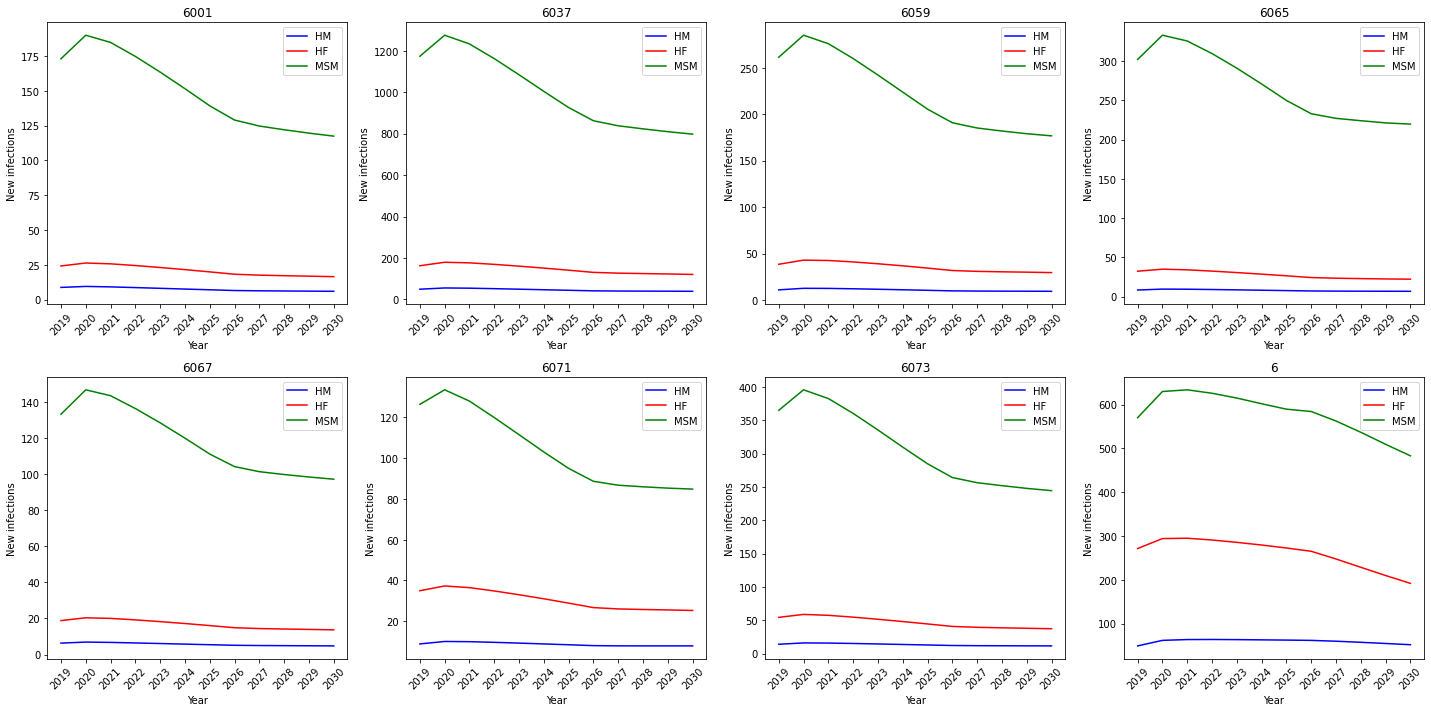

In [37]:
def plot_new_inf(new_inf_over_years):
    
    num_jur = user_input_dict["num_jur"]
    all_jur = user_input_dict["all_jurisdictions"]
    number_of_risk_groups = user_input_dict["number_of_risk_groups"]
    risk_groups = user_input_dict["risk_groups"]
    simulating_years = user_input_dict["simulating_years"]
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    
    colors = ['b', 'r', 'g']
    
    for i in range(num_jur):
        for j in range(number_of_risk_groups):
            
            if i<=3:
                x_i = 0
                y_i = i
            else:
                x_i = 1
                y_i = i-4
                            
            y = np.sum(new_inf_over_years[:,i,j], axis = 1)
            x = np.arange(len(y))

            axs[x_i, y_i].plot(x, y, colors[j], label = risk_groups[j])
            axs[x_i, y_i].set_title(all_jur[i])
            axs[x_i, y_i].legend()
            axs[x_i, y_i].set_xlabel('Year')
            axs[x_i, y_i].set_ylabel('New infections')
            axs[x_i, y_i].set_xticks(x)
            axs[x_i, y_i].set_xticklabels(simulating_years)
            axs[x_i, y_i].tick_params(axis='x', rotation=45)

    # Adjust the layout to prevent overlap
    plt.tight_layout()

    # Display the plot
    plt.show()
        

    
    
    
plot_new_inf(new_inf_over_years)  

In [34]:
integer_list = list(range(2019, 2030+1))
integer_list

[2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]